In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier # RandomForestClassifier

In [3]:
%matplotlib inline
from sklearn.datasets import make_blobs

Step One

Importing Severe Weather Test Data

In [4]:
# importing test weather data
weather_df = pd.read_csv("SevereWeatherDetails_appended2.csv", low_memory=False)

In [5]:
weather_df.head()

,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON
0,10096222,OKLAHOMA,40,1950,April,Tornado,0,0,0,0,250K,0,0.0,0.0,F3,3.4,400.0,35.12,-99.20
1,10120412,TEXAS,48,1950,April,Tornado,0,0,0,0,25K,0,0.0,0.0,F1,11.5,200.0,31.90,-98.60
2,10104927,PENNSYLVANIA,42,1950,July,Tornado,2,0,0,0,25K,0,0.0,0.0,F2,12.9,33.0,40.58,-75.70
3,10104928,PENNSYLVANIA,42,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,0.0,F2,0.0,13.0,40.60,-76.75
4,10104929,PENNSYLVANIA,42,1950,July,Tornado,0,0,0,0,2.5K,0,0.0,0.0,F0,0.0,33.0,41.63,-79.68


In [6]:
# dropping columns not needed
weather_df = weather_df.drop(columns=['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
                                     'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'TOR_F_SCALE', 'TOR_LENGTH',
                                     'TOR_WIDTH', 'BEGIN_LAT', 'BEGIN_LON', 'STATE_FIPS','STATE','CATEGORY'])

In [7]:
weather_df = weather_df.drop(weather_df[weather_df.YEAR > 2000].index)

In [8]:
# displaying weather df
weather_df.head()

,EVENT_ID,YEAR,MONTH_NAME,EVENT_TYPE
0,10096222,1950,April,Tornado
1,10120412,1950,April,Tornado
2,10104927,1950,July,Tornado
3,10104928,1950,July,Tornado
4,10104929,1950,July,Tornado


In [9]:
# adding together events by groups
group_groups = weather_df.groupby(['YEAR','MONTH_NAME', 'EVENT_TYPE'], as_index=False).count()
print(group_groups.head(10))
print(group_groups.tail(10))

   YEAR MONTH_NAME EVENT_TYPE  EVENT_ID
0  1950      April    Tornado        17
1  1950     August    Tornado        14
2  1950   December    Tornado         6
3  1950   February    Tornado        27
4  1950    January    Tornado         8
5  1950       July    Tornado        23
6  1950       June    Tornado        30
7  1950      March    Tornado        24
8  1950        May    Tornado        64
9  1950   November    Tornado         5
      YEAR MONTH_NAME         EVENT_TYPE  EVENT_ID
2964  2000  September          Lightning        94
2965  2000  September        Rip Current         3
2966  2000  September   Storm Surge/Tide         1
2967  2000  September        Strong Wind         1
2968  2000  September  Thunderstorm Wind       787
2969  2000  September            Tornado        51
2970  2000  September     Tropical Storm        43
2971  2000  September         Waterspout        29
2972  2000  September           Wildfire        45
2973  2000  September       Winter Storm        33

In [10]:
# rename 'EVENT_ID' column as 'Count' and 'YEAR' as 'Year'
group_groups = group_groups.rename(columns={'EVENT_ID': 'Count', 'YEAR': 'Year'})
group_groups.head()

,Year,MONTH_NAME,EVENT_TYPE,Count
0,1950,April,Tornado,17
1,1950,August,Tornado,14
2,1950,December,Tornado,6
3,1950,February,Tornado,27
4,1950,January,Tornado,8


In [11]:
# Co2 Below This

In [12]:
# importing test co2 data 
carbon_df = pd.read_csv("co2_byYear.csv", low_memory=False)

In [13]:
# display co2 data
carbon_df

,year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [14]:
# rename columns for merging purposes
carbon_df = carbon_df.rename(columns={"year": "Year"})
carbon_df

,Year,co2,co2_per_capita,co2_per_unit_energy,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,1950,23193.336,943.286,0.000,15959.768,272.887,223.550,1110.931,5611.231,9.976,...,0.000,0.00,0.000,0.00,0.000,7.570713e+09,1.585967e+13,0.000,0.000,0.000
1,1951,24765.194,1214.978,0.000,16981.583,309.265,243.305,1306.674,5907.881,11.002,...,0.000,0.00,0.000,0.00,0.000,7.712655e+09,7.992201e+12,0.000,0.000,0.000
2,1952,25203.424,834.737,0.000,16927.201,331.430,259.877,1405.429,6263.420,10.710,...,0.000,0.00,0.000,0.00,0.000,7.852545e+09,8.401431e+12,0.000,0.000,0.000
3,1953,25929.893,880.578,0.000,17104.163,368.454,248.979,1498.933,6689.993,12.910,...,0.000,0.00,0.000,0.00,0.000,7.992062e+09,8.884521e+12,0.000,0.000,0.000
4,1954,26744.552,1378.627,0.000,17319.801,400.182,236.584,1588.220,7182.609,11.442,...,0.000,0.00,0.000,0.00,0.000,8.133217e+09,9.099744e+12,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2016,124705.642,1156.831,44.924,48325.275,4990.527,1438.122,27011.160,41892.058,1048.509,...,1415.378,17424.08,345.519,6291.93,105.005,2.239131e+10,2.147076e+14,366170.181,5562418.068,208.589
67,2017,126304.716,1156.251,18.863,48587.789,5067.569,1576.265,27603.881,42412.614,1056.584,...,0.000,0.00,0.000,0.00,0.000,2.264281e+10,2.211738e+14,366923.317,3678183.705,0.000
68,2018,128452.538,1152.783,18.444,49368.748,5286.347,1531.205,28781.873,42422.168,1062.207,...,0.000,0.00,0.000,0.00,0.000,2.289184e+10,2.276454e+14,376507.961,3698476.648,0.000
69,2019,128422.887,1165.000,18.142,48731.161,5408.677,1611.674,29061.768,42547.578,1062.016,...,0.000,0.00,0.000,0.00,0.000,2.313895e+10,0.000000e+00,380148.487,3659567.475,0.000


In [15]:
# dropping columns not needed
carbon_df = carbon_df.drop(columns=['co2_per_unit_energy', 'coal_co2', 'cement_co2', 'flaring_co2', 'gas_co2',
                                         'oil_co2', 'other_industry_co2', 'ghg_per_capita', 'methane', 'methane_per_capita',
                                         'nitrous_oxide', 'nitrous_oxide_per_capita', 'population', 'gdp', 'primary_energy_consumption',
                                         'energy_per_capita', 'energy_per_gdp', 'total_ghg'])

In [16]:
carbon_df = carbon_df.drop(carbon_df[carbon_df.Year > 2000].index)

In [17]:
# show new dataframe
carbon_df

,Year,co2,co2_per_capita
0,1950,23193.336,943.286
1,1951,24765.194,1214.978
2,1952,25203.424,834.737
3,1953,25929.893,880.578
4,1954,26744.552,1378.627
5,1955,29264.525,1214.075
6,1956,31190.093,1417.809
7,1957,32296.584,1096.454
8,1958,33117.274,996.436
9,1959,34633.663,1119.316


In [18]:
# Merge attempt one
combo_df = group_groups.merge(carbon_df, left_on='Year', right_on='Year')

In [19]:
# checking merge
combo_df

,Year,MONTH_NAME,EVENT_TYPE,Count,co2,co2_per_capita
0,1950,April,Tornado,17,23193.336,943.286
1,1950,August,Tornado,14,23193.336,943.286
2,1950,December,Tornado,6,23193.336,943.286
3,1950,February,Tornado,27,23193.336,943.286
4,1950,January,Tornado,8,23193.336,943.286
...,...,...,...,...,...,...
2969,2000,September,Tornado,51,92998.026,1174.210
2970,2000,September,Tropical Storm,43,92998.026,1174.210
2971,2000,September,Waterspout,29,92998.026,1174.210
2972,2000,September,Wildfire,45,92998.026,1174.210


In [20]:
# Print out the # of yearly events value counts
count_counts = combo_df.Count.value_counts()
count_counts

1       177
3        89
2        82
5        67
4        62
       ... 
872       1
870       1
836       1
828       1
1983      1
Name: Count, Length: 607, dtype: int64

In [21]:
count_counts.head()

1    177
3     89
2     82
5     67
4     62
Name: Count, dtype: int64

<AxesSubplot:ylabel='Density'>

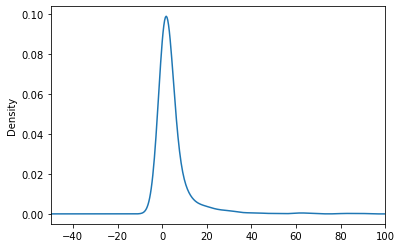

In [22]:
# Visualize the value counts
count_counts.plot.density(xlim=(-50,100))

In [23]:
# Determine which values to replace
replace_counts = list(count_counts[count_counts < 3].index)

# Replace in DataFrame
#for count in replace_counts:
#    combo_df.Count = combo_df.Count.replace(count,0)

# remove values that occur less than 3 times
combo_df = combo_df[~combo_df['Count'].isin(replace_counts)]


# Check to make sure binning was successful
combo_df.Count.value_counts()

1      177
3       89
2       82
5       67
4       62
      ... 
106      3
153      3
161      3
169      3
621      3
Name: Count, Length: 221, dtype: int64

In [24]:
# Adding machine learning model parameters below here

In [25]:
target = ["Count"]

In [26]:
# split data into training and testing

# Create our features
X = pd.get_dummies(combo_df.drop(columns="Count"))

# Create our target
y = pd.get_dummies(combo_df["Count"])

In [27]:
X.describe()

,Year,co2,co2_per_capita,MONTH_NAME_April,MONTH_NAME_August,MONTH_NAME_December,MONTH_NAME_February,MONTH_NAME_January,MONTH_NAME_July,MONTH_NAME_June,...,EVENT_TYPE_TORNADO/WATERSPOUT,"EVENT_TYPE_TORNADOES, TSTM WIND, HAIL",EVENT_TYPE_Thunderstorm Wind,EVENT_TYPE_Tornado,EVENT_TYPE_Tropical Storm,EVENT_TYPE_Volcanic Ash,EVENT_TYPE_Waterspout,EVENT_TYPE_Wildfire,EVENT_TYPE_Winter Storm,EVENT_TYPE_Winter Weather
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,...,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,1985.197442,74933.409833,1161.315006,0.081535,0.077138,0.091127,0.093125,0.086731,0.068745,0.063549,...,0.000400,0.000400,0.145883,0.227818,0.005995,0.000799,0.023181,0.021183,0.009193,0.012790
std,15.492662,21372.125338,115.447021,0.273709,0.266864,0.287847,0.290666,0.281496,0.253071,0.243997,...,0.019992,0.019992,0.353060,0.419508,0.077212,0.028267,0.150510,0.144023,0.095456,0.112389
min,1950.000000,23193.336000,834.737000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1972.000000,63821.145000,1082.779000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1995.000000,88759.479000,1135.557000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1998.000000,90055.545000,1174.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2000.000000,92998.026000,1523.389000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# Check the balance of our target values
y = combo_df['Count']
y.value_counts()

1      177
3       89
2       82
5       67
4       62
      ... 
106      3
153      3
161      3
169      3
621      3
Name: Count, Length: 221, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({23: 18,
         65: 10,
         24: 15,
         28: 20,
         13: 25,
         128: 5,
         39: 15,
         1: 133,
         33: 14,
         9: 24,
         233: 2,
         41: 11,
         127: 3,
         87: 8,
         232: 4,
         56: 8,
         46: 8,
         27: 14,
         152: 6,
         36: 11,
         281: 2,
         2: 61,
         5: 50,
         38: 16,
         22: 15,
         51: 11,
         91: 5,
         11: 29,
         26: 20,
         58: 4,
         190: 3,
         6: 38,
         78: 8,
         84: 6,
         52: 6,
         225: 3,
         177: 4,
         43: 12,
         12: 25,
         3: 67,
         32: 11,
         183: 5,
         14: 21,
         143: 4,
         35: 10,
         244: 2,
         116: 4,
         8: 33,
         253: 3,
         15: 17,
         147: 5,
         55: 13,
         139: 5,
         49: 19,
         81: 8,
         67: 6,
         21: 21,
         4: 46,
         63: 9,
         135: 4

In [30]:
# resample the training data with the BalancedRandomForestClassifier

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
brfc = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brfc.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [31]:
# display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = brfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [32]:
# calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.0

In [33]:
# print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00      44.0
          2       0.00      0.00      1.00      0.00      0.00      0.00      21.0
          3       0.00      0.00      1.00      0.00      0.00      0.00      22.0
          4       0.00      0.00      1.00      0.00      0.00      0.00      16.0
          5       0.00      0.00      1.00      0.00      0.00      0.00      17.0
          6       0.00      0.00      1.00      0.00      0.00      0.00      13.0
          7       0.00      0.00      1.00      0.00      0.00      0.00      15.0
          8       0.00      0.00      1.00      0.00      0.00      0.00      11.0
          9       0.00      0.00      1.00      0.00      0.00      0.00       8.0
         10       0.00      0.00      1.00      0.00      0.00      0.00      10.0
         11       0.00      0.00      1.00      0.00      0.00      0.00      10.0
   

In [34]:
# list the features sorted in descending order by feature importance
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)

[(0.16787519501942777, 'Year'),
 (0.1647977085944702, 'co2_per_capita'),
 (0.16463904706418414, 'co2'),
 (0.030890300916414946, 'EVENT_TYPE_Tornado'),
 (0.028533464686595247, 'EVENT_TYPE_Hail'),
 (0.026286647929307516, 'EVENT_TYPE_Thunderstorm Wind'),
 (0.024019801391237806, 'MONTH_NAME_April'),
 (0.02357137532366066, 'MONTH_NAME_July'),
 (0.02246568795423929, 'MONTH_NAME_March'),
 (0.022347321431462026, 'MONTH_NAME_August'),
 (0.022338980812049804, 'MONTH_NAME_June'),
 (0.021120750730506836, 'MONTH_NAME_May'),
 (0.01993104509735862, 'MONTH_NAME_November'),
 (0.019062909326719907, 'MONTH_NAME_September'),
 (0.01876647928942756, 'MONTH_NAME_October'),
 (0.017518069588954924, 'MONTH_NAME_February'),
 (0.017309177521800452, 'MONTH_NAME_December'),
 (0.014389996080335641, 'MONTH_NAME_January'),
 (0.01377604521954058, 'EVENT_TYPE_Flash Flood'),
 (0.011262034926631704, 'EVENT_TYPE_Flood'),
 (0.010960971685689274, 'EVENT_TYPE_Lightning'),
 (0.01074754925301194, 'EVENT_TYPE_High Wind'),
 (0.00

# Easy Ensemble AdaBoost Classifier

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({23: 18,
         65: 10,
         24: 15,
         28: 20,
         13: 25,
         128: 5,
         39: 15,
         1: 133,
         33: 14,
         9: 24,
         233: 2,
         41: 11,
         127: 3,
         87: 8,
         232: 4,
         56: 8,
         46: 8,
         27: 14,
         152: 6,
         36: 11,
         281: 2,
         2: 61,
         5: 50,
         38: 16,
         22: 15,
         51: 11,
         91: 5,
         11: 29,
         26: 20,
         58: 4,
         190: 3,
         6: 38,
         78: 8,
         84: 6,
         52: 6,
         225: 3,
         177: 4,
         43: 12,
         12: 25,
         3: 67,
         32: 11,
         183: 5,
         14: 21,
         143: 4,
         35: 10,
         244: 2,
         116: 4,
         8: 33,
         253: 3,
         15: 17,
         147: 5,
         55: 13,
         139: 5,
         49: 19,
         81: 8,
         67: 6,
         21: 21,
         4: 46,
         63: 9,
         135: 4

In [37]:
# Train the EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

X, y = load_iris(return_X_y=True)
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
scores = cross_val_score(eec, X, y, cv=5)
scores.mean()

0.9466666666666667

In [38]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [40]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = eec.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1, 0, 0, ..., 1, 6, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.00717297408473879

In [42]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       1.00      0.02      1.00      0.04      0.15      0.02        44
          2       0.00      0.00      1.00      0.00      0.00      0.00        21
          3       0.00      0.00      1.00      0.00      0.00      0.00        22
          4       0.12      0.06      0.99      0.08      0.25      0.06        16
          5       0.00      0.00      1.00      0.00      0.00      0.00        17
          6       0.00      0.00      1.00      0.00      0.00      0.00        13
          7       0.00      0.00      1.00      0.00      0.00      0.00        15
          8       0.00      0.00      1.00      0.00      0.00      0.00        11
          9       0.00      0.00      1.00      0.00      0.00      0.00         8
         10       0.00      0.00      1.00      0.00      0.00      0.00        10
         11       0.00      0.00      1.00      0.00      0.00      0.00        10
   

In [47]:
# list the features sorted in descending order by feature importance
sorted(zip(eec.feature_importances_, X.columns), reverse=True)

AttributeError: 'EasyEnsembleClassifier' object has no attribute 'feature_importances_'